# Orlen fuel prices analysis
The project aims to compare wholesale fuel prices offered in Poland with brent crude oil purchase prices and the USD/PLN exchange rate. The aim is to determine changes in fuel prices on the Polish market in relation to economic changes, and to determine whether there are periods when fuel prices did not correlate with other factors affecting them.

In [1]:
import pandas as pd 
import os
import requests
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import seaborn as sns
from dotenv import load_dotenv
from datetime import datetime, timedelta
import numpy as np

load_dotenv()

True

## 1. Downloading data

In [2]:
# Downloading historical brent oil price data from a csv file
brent = pd.read_csv('Brent od 01-01-2014.csv')  
brent

,Data,Ostatnio,Otwarcie,Max.,Min.,Wol.,Zmiana%
0,17.01.2024,"78,03","77,78","78,14","76,52",NaN,"-0,33%"
1,16.01.2024,"78,29","78,43","79,40","77,60","298,55K","0,18%"
2,15.01.2024,"78,15","78,14","78,90","76,85","177,69K","-0,18%"
3,12.01.2024,"78,29","78,75","80,75","77,96","401,34K","1,14%"
4,11.01.2024,"77,41","76,70","79,10","76,66","396,77K","0,79%"
...,...,...,...,...,...,...,...
2589,07.01.2014,"107,35","107,03","107,72","106,88","188,20K","0,58%"
2590,06.01.2014,"106,73","106,80","107,96","106,58","181,82K","-0,15%"
2591,03.01.2014,"106,89","107,88","108,64","106,79","191,13K","-0,83%"
2592,02.01.2014,"107,78","111,00","111,35","107,65","200,65K","-2,83%"


In [3]:
# Downloading USD exchange rate histyory data from a CSV file
USD = pd.read_csv('USD_01-01-2014-2024.csv')
USD

,Tabela,Data,Kurs średni,Zmiana
0,12/A/NBP/2024,2024-01-17,4.0434,0.19
1,11/A/NBP/2024,2024-01-16,4.0358,0.99
2,10/A/NBP/2024,2024-01-15,3.9963,0.55
3,9/A/NBP/2024,2024-01-12,3.9746,0.17
4,8/A/NBP/2024,2024-01-11,3.9680,0.06
...,...,...,...,...
2529,5/A/NBP/2014,2014-01-09,3.0695,-0.07
2530,4/A/NBP/2014,2014-01-08,3.0717,0.09
2531,3/A/NBP/2014,2014-01-07,3.0688,0.56
2532,2/A/NBP/2014,2014-01-03,3.0517,0.67


In [4]:
# Downloading data on wholesale ON prices from the lotos.pl website.
# URL of the fuel prices page
url = 'https://www.lotos.pl/145/type,oil_eurodiesel/dla_biznesu/hurtowe_ceny_paliw/archiwum_cen_paliw'

# Setting the date range
start_date = datetime(2014, 1, 1)
end_date = datetime(2023, 12, 31)

# Function to retrieve and process data
def scrape_fuel_prices(url, start_date, end_date):
    data = []
    
    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'html.parser')
    
    table = soup.find('table')
    rows = table.find_all('tr')[1:]  

    for row in rows:
        cols = row.find_all('td')
        date_str = cols[0].text.strip()
        price = cols[1].text.strip()  
        
        date = datetime.strptime(date_str, '%Y-%m-%d')
        
        if start_date <= date <= end_date:
            data.append({'date': date, 'price': price})

    df = pd.DataFrame(data)
    return df

diesel_prices = scrape_fuel_prices(url, start_date, end_date)

In [5]:
diesel_prices

,date,price
0,2023-12-30,"4 965,00"
1,2023-12-29,"5 009,00"
2,2023-12-28,"5 049,00"
3,2023-12-23,"5 082,00"
4,2023-12-22,"5 090,00"
...,...,...
2504,2014-01-08,"4 146,00"
2505,2014-01-04,"4 143,00"
2506,2014-01-03,"4 160,00"
2507,2014-01-02,"4 196,00"


## 2. Data unification

In [6]:
# Standardize the date format of collected data
brent['Data'] = pd.to_datetime(brent["Data"])
USD['Data'] = pd.to_datetime(USD["Data"])
diesel_prices['Data'] = pd.to_datetime(diesel_prices["date"], format='%d.%m.%Y')

C:\Users\MariuszKamiński\AppData\Local\Temp\ipykernel_10632\1196889892.py:2: UserWarning: Parsing dates in %d.%m.%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  brent['Data'] = pd.to_datetime(brent["Data"])


In [7]:
# Merging DataFrames
merged_df = pd.merge(brent, USD, on='Data', how='inner')
merged_df = pd.merge(merged_df, diesel_prices, left_on='Data', right_on='Data', how='inner')
merged_df.head()

,Data,Ostatnio,Otwarcie,Max.,Min.,Wol.,Zmiana%,Tabela,Kurs średni,Zmiana,date,price
0,2023-12-29,"77,04","77,38","77,98","76,73","192,95K","-1,72%",251/A/NBP/2023,3.9350,0.92,2023-12-29,"5 009,00"
1,2023-12-28,"78,39","79,80","79,95","78,25","18,78K","-1,58%",250/A/NBP/2023,3.8990,-0.48,2023-12-28,"5 049,00"
2,2023-12-22,"79,07","79,35","80,37","78,88","119,19K","-0,40%",248/A/NBP/2023,3.9338,-0.77,2023-12-22,"5 090,00"
3,2023-12-21,"79,39","79,00","80,13","77,81","193,32K","-0,39%",247/A/NBP/2023,3.9645,0.30,2023-12-21,"5 082,00"
4,2023-12-20,"79,70","79,17","80,60","79,07","241,81K","0,59%",246/A/NBP/2023,3.9527,-0.16,2023-12-20,"5 039,00"


In [8]:
# Removal of unnecessary columns
merged_df = merged_df.drop(columns=['Otwarcie', 'Max.', 'Min.', 'Wol.', 'Zmiana%', 'Tabela', 'Zmiana', 'date'])
merged_df.head()

,Data,Ostatnio,Kurs średni,price
0,2023-12-29,"77,04",3.9350,"5 009,00"
1,2023-12-28,"78,39",3.8990,"5 049,00"
2,2023-12-22,"79,07",3.9338,"5 090,00"
3,2023-12-21,"79,39",3.9645,"5 082,00"
4,2023-12-20,"79,70",3.9527,"5 039,00"


In [9]:
# Renaming columns
merged_df = merged_df.rename(columns={'Ostatnio': 'Brent USD/b',
                                      'Kurs średni': 'PLN/USD',
                                      'price': 'Eurodiesel'})
merged_df.set_index('Data', inplace=True)
merged_df.head()
merged_df.dtypes

Brent USD/b     object
PLN/USD        float64
Eurodiesel      object
dtype: object

In [10]:
# Change decimal separators from ',' to '.', change data type from int to float, remove white spaces
merged_df['Brent USD/b'] = merged_df['Brent USD/b'].str.replace(',', '.').str.replace(' ', '').astype(float)
merged_df['Eurodiesel'] = merged_df['Eurodiesel'].str.replace(',', '.').str.replace(' ', '').astype(float)
merged_df.dtypes

Brent USD/b    float64
PLN/USD        float64
Eurodiesel     float64
dtype: object

In [11]:
are_any_cells_empty = merged_df.isna().any().any()
print("Czy są jakieś puste komórki w DataFrame:", are_any_cells_empty)


Czy są jakieś puste komórki w DataFrame: False


In [12]:
merged_df

,Brent USD/b,PLN/USD,Eurodiesel
Data,,,
2023-12-29,77.04,3.9350,5009.0
2023-12-28,78.39,3.8990,5049.0
2023-12-22,79.07,3.9338,5090.0
2023-12-21,79.39,3.9645,5082.0
2023-12-20,79.70,3.9527,5039.0
...,...,...,...
2014-01-10,107.25,3.0700,4136.0
2014-01-09,106.39,3.0695,4150.0
2014-01-08,107.15,3.0717,4146.0


## 3. Data analysis

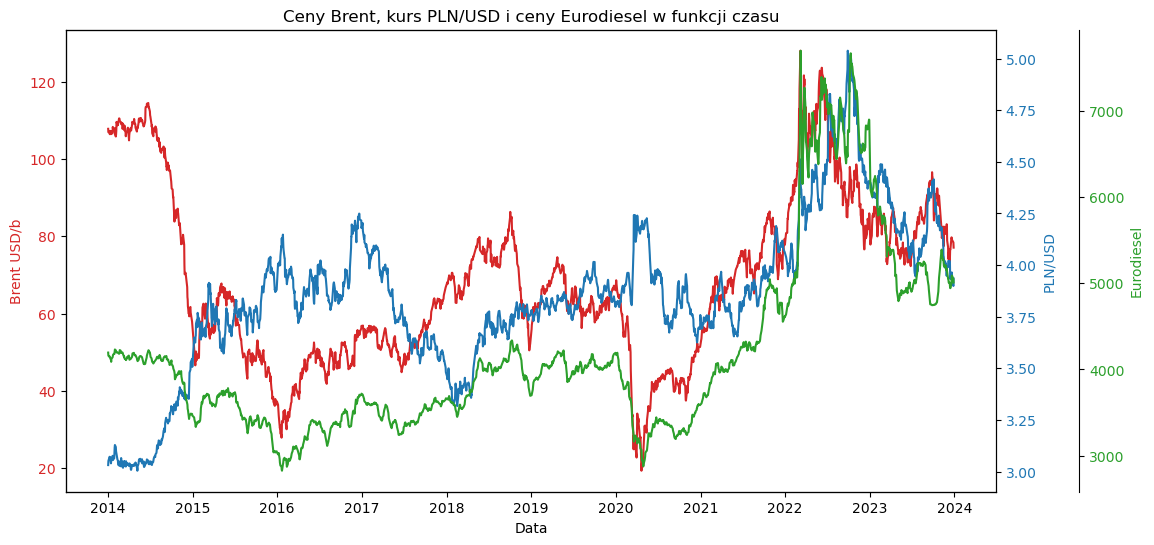

In [13]:
# Create a summary chart of the data
fig, ax1 = plt.subplots(figsize=(12, 6))

color = 'tab:red'
ax1.set_xlabel('Data')
ax1.set_ylabel('Brent USD/b', color=color)
ax1.plot(merged_df['Brent USD/b'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  
color = 'tab:blue'
ax2.set_ylabel('PLN/USD', color=color)  
ax2.plot(merged_df['PLN/USD'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

ax3 = ax1.twinx()
color = 'tab:green'
ax3.spines['right'].set_position(('outward', 60))      
ax3.set_ylabel('Eurodiesel', color=color)
ax3.plot(merged_df['Eurodiesel'], color=color)
ax3.tick_params(axis='y', labelcolor=color)

plt.title('Ceny Brent, kurs PLN/USD i ceny Eurodiesel w funkcji czasu')

plt.show()

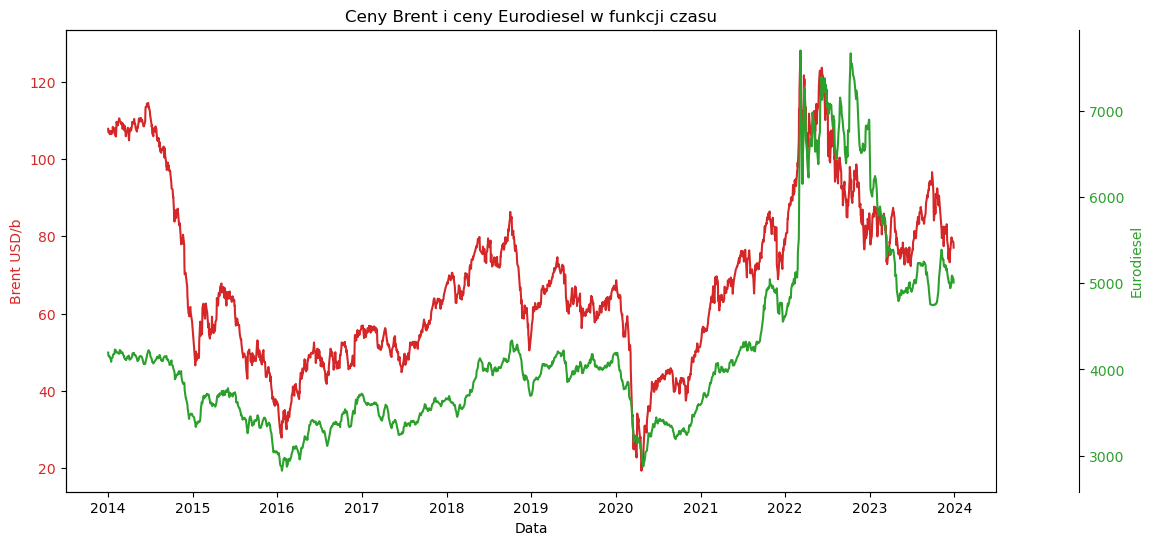

In [14]:
# Create a summary chart of the data
fig, ax1 = plt.subplots(figsize=(12, 6))

color = 'tab:red'
ax1.set_xlabel('Data')
ax1.set_ylabel('Brent USD/b', color=color)
ax1.plot(merged_df['Brent USD/b'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:green'
ax2.spines['right'].set_position(('outward', 60))      
ax2.set_ylabel('Eurodiesel', color=color)
ax2.plot(merged_df['Eurodiesel'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Ceny Brent i ceny Eurodiesel w funkcji czasu')

plt.show()

In [15]:
# Analysis of correlations between data series throughout the study period
macierz_korelacji = merged_df.corr()
macierz_korelacji

,Brent USD/b,PLN/USD,Eurodiesel
Brent USD/b,1.000000,-0.035190,0.742698
PLN/USD,-0.035190,1.000000,0.588833
Eurodiesel,0.742698,0.588833,1.000000


In [16]:
# Conversion of Brent crude oil barrel prices to PLN
brent_PLN = merged_df.copy()
brent_PLN['Brent PLN/b'] = brent_PLN['Brent USD/b'] * brent_PLN['PLN/USD']
brent_PLN

,Brent USD/b,PLN/USD,Eurodiesel,Brent PLN/b
Data,,,,
2023-12-29,77.04,3.9350,5009.0,303.152400
2023-12-28,78.39,3.8990,5049.0,305.642610
2023-12-22,79.07,3.9338,5090.0,311.045566
2023-12-21,79.39,3.9645,5082.0,314.741655
2023-12-20,79.70,3.9527,5039.0,315.030190
...,...,...,...,...
2014-01-10,107.25,3.0700,4136.0,329.257500
2014-01-09,106.39,3.0695,4150.0,326.564105
2014-01-08,107.15,3.0717,4146.0,329.132655


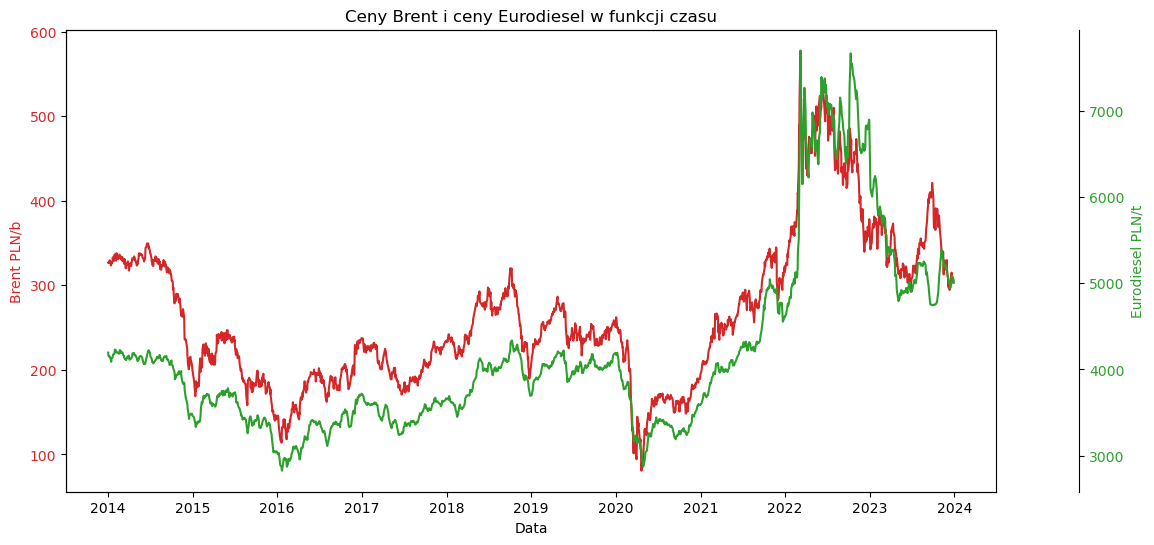

In [17]:
# Visualization of brent oil and eurodiesel price waveforms as a function of time
fig, ax1 = plt.subplots(figsize=(12, 6))

color = 'tab:red'
ax1.set_xlabel('Data')
ax1.set_ylabel('Brent PLN/b', color=color)
ax1.plot(brent_PLN['Brent PLN/b'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:green'
ax2.spines['right'].set_position(('outward', 60))      
ax2.set_ylabel('Eurodiesel PLN/t', color=color)
ax2.plot(brent_PLN['Eurodiesel'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Ceny Brent i ceny Eurodiesel w funkcji czasu')

plt.show()

In [18]:
# Analysis of correlations between data series throughout the study period
macierz_korelacji_2 = brent_PLN.corr()
macierz_korelacji_2

,Brent USD/b,PLN/USD,Eurodiesel,Brent PLN/b
Brent USD/b,1.000000,-0.035190,0.742698,0.920090
PLN/USD,-0.035190,1.000000,0.588833,0.350902
Eurodiesel,0.742698,0.588833,1.000000,0.927633
Brent PLN/b,0.920090,0.350902,0.927633,1.000000


In [19]:
brent_PLN.head()

,Brent USD/b,PLN/USD,Eurodiesel,Brent PLN/b
Data,,,,
2023-12-29,77.04,3.9350,5009.0,303.152400
2023-12-28,78.39,3.8990,5049.0,305.642610
2023-12-22,79.07,3.9338,5090.0,311.045566
2023-12-21,79.39,3.9645,5082.0,314.741655
2023-12-20,79.70,3.9527,5039.0,315.030190


## 4. Development of a model to predict Eurodiesel prices based on the PLN brent oil rate

### 4.1 Preparation of data for modeling
Preparation includes assigning data to variables and labels and dividing them for the teaching and testing set.

In [90]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [91]:
base_brent_PLN = brent_PLN[:'2021-12-31'].copy()
base_brent_PLN

,Brent USD/b,PLN/USD,Eurodiesel,Brent PLN/b
Data,,,,
2021-12-31,77.78,4.0600,4611.0,315.786800
2021-12-30,79.32,4.0631,4618.0,322.285092
2021-12-24,76.14,4.0785,4565.0,310.536990
2021-12-23,76.85,4.0950,4561.0,314.700750
2021-12-22,75.29,4.0984,4554.0,308.568536
...,...,...,...,...
2014-01-10,107.25,3.0700,4136.0,329.257500
2014-01-09,106.39,3.0695,4150.0,326.564105
2014-01-08,107.15,3.0717,4146.0,329.132655


In [92]:
# Division of data into independent variables 'X' and dependent variable 'y'
X = base_brent_PLN[['Brent PLN/b']]  
y = base_brent_PLN['Eurodiesel']  


In [93]:
# Splitting data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### 4.2 Modeling by linear regression

In [94]:
# Construction of a linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [95]:
# Predicting on a test set
y_pred = model.predict(X_test)

In [96]:
# Model evaluation
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'MSE: {mse}')
print(f'R2 Score: {r2}')

MSE: 30941.32210848293
R2 Score: 0.8273826410636077


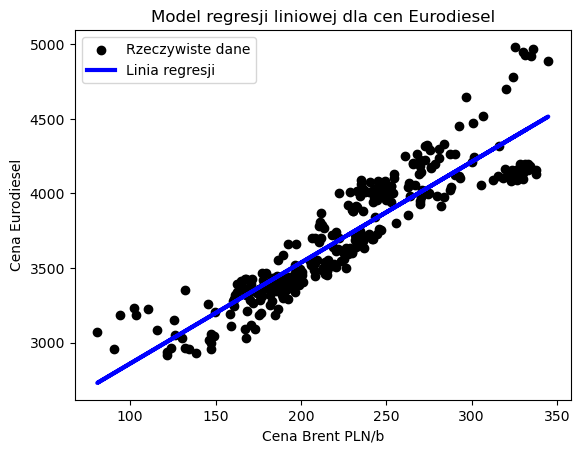

In [97]:
import matplotlib.pyplot as plt

# Scatter plot of test data
plt.scatter(X_test, y_test, color='black', label='Rzeczywiste dane')

# Line of regression
plt.plot(X_test, y_pred, color='blue', linewidth=3, label='Linia regresji')

plt.title('Model regresji liniowej dla cen Eurodiesel')
plt.xlabel('Cena Brent PLN/b')
plt.ylabel('Cena Eurodiesel')

plt.legend()
plt.show()


In [98]:
brent_PLN_2022 = brent_PLN['2022-01-05':].copy()
brent_PLN_2022

,Brent USD/b,PLN/USD,Eurodiesel,Brent PLN/b
Data,,,,
2023-12-29,77.04,3.9350,5009.0,303.152400
2023-12-28,78.39,3.8990,5049.0,305.642610
2023-12-22,79.07,3.9338,5090.0,311.045566
2023-12-21,79.39,3.9645,5082.0,314.741655
2023-12-20,79.70,3.9527,5039.0,315.030190
...,...,...,...,...
2022-01-13,84.47,3.9463,4767.0,333.343961
2022-01-12,84.67,3.9879,4755.0,337.655493
2022-01-11,83.72,4.0106,4735.0,335.767432


In [99]:
# Evaluation of model performance on data from 2022
X_predict = brent_PLN_2022[['Brent PLN/b']]
predicted_eurodiesel_prices = model.predict(X_predict)
brent_PLN_2022['Predicted Eurodiesel Price'] = predicted_eurodiesel_prices
brent_PLN_2022

,Brent USD/b,PLN/USD,Eurodiesel,Brent PLN/b,Predicted Eurodiesel Price
Data,,,,,
2023-12-29,77.04,3.9350,5009.0,303.152400,4233.204118
2023-12-28,78.39,3.8990,5049.0,305.642610,4250.041084
2023-12-22,79.07,3.9338,5090.0,311.045566,4286.571892
2023-12-21,79.39,3.9645,5082.0,314.741655,4311.562123
2023-12-20,79.70,3.9527,5039.0,315.030190,4313.512984
...,...,...,...,...,...
2022-01-13,84.47,3.9463,4767.0,333.343961,4437.337211
2022-01-12,84.67,3.9879,4755.0,337.655493,4466.488614
2022-01-11,83.72,4.0106,4735.0,335.767432,4453.722937


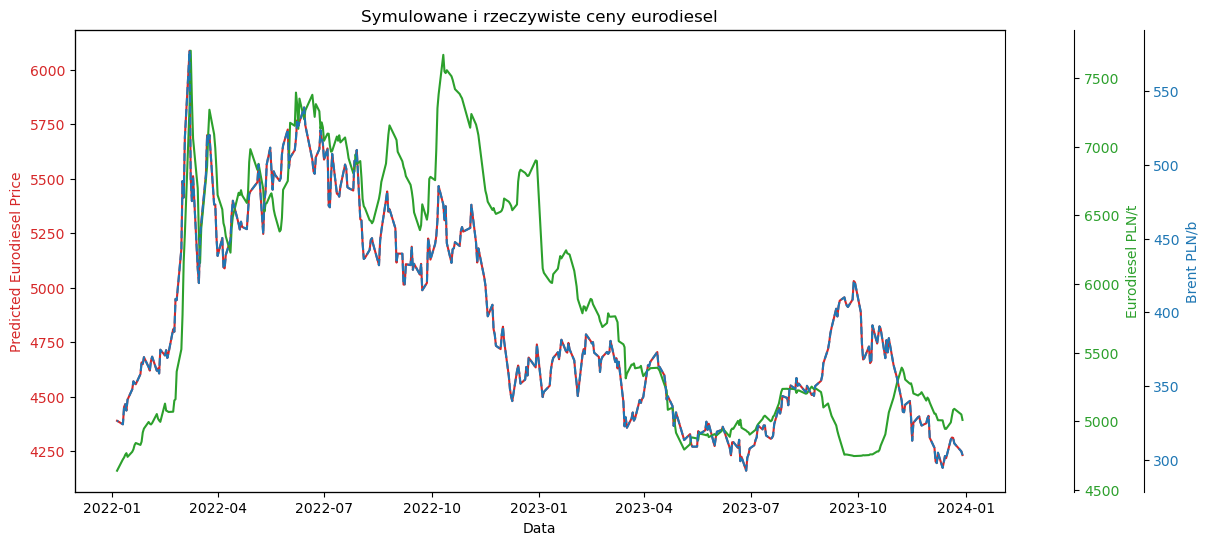

In [100]:
# Create a comparative chart of model and actual data
fig, ax1 = plt.subplots(figsize=(12, 6))

color = 'tab:red'
ax1.set_xlabel('Data')
ax1.set_ylabel('Predicted Eurodiesel Price', color=color)
ax1.plot(brent_PLN_2022['Predicted Eurodiesel Price'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:green'
ax2.spines['right'].set_position(('outward', 50))      
ax2.set_ylabel('Eurodiesel PLN/t', color=color)
ax2.plot(brent_PLN_2022['Eurodiesel'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

ax3 = ax1.twinx()
ax3.set_xlabel('Data')
color = 'tab:blue'
ax3.spines['right'].set_position(('outward', 100))
ax3.set_ylabel('Brent PLN/b', color=color)
ax3.plot(brent_PLN_2022['Brent PLN/b'], color=color, linestyle='--')
ax3.tick_params(axis='y', labelcolor=color)

plt.title('Symulowane i rzeczywiste ceny eurodiesel')

plt.show()

Analiza powyższego wykresu wskazuje, że w okresie 11.2022-01.2023 oraz 09.2023-11.2023 ceny paliwa Eurodiesel znacząco odbiegają od cen ropy brent oraz wartości modelowych. Mogłoby to wskazywać na pozarynkowe przyczyny poziomu cen.

<Axes: xlabel='Data'>

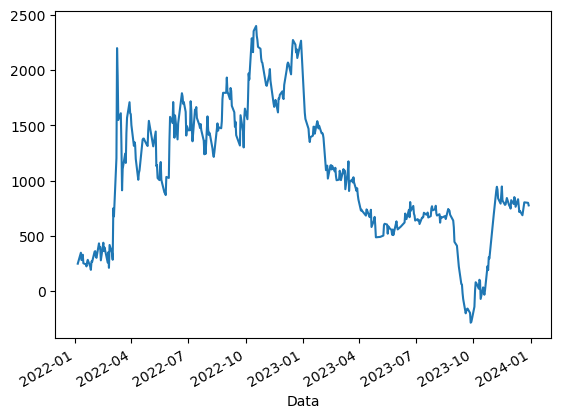

In [101]:
# Calculation of residuals
brent_PLN_2022['Residuals'] = brent_PLN_2022['Eurodiesel'] - brent_PLN_2022['Predicted Eurodiesel Price']
brent_PLN_2022['Residuals'].plot()

In [102]:
residuals_std_dev = np.std(brent_PLN_2022['Residuals'])
mean = np.mean(brent_PLN_2022['Residuals'])
brent_PLN_2022['Anomaly'] = brent_PLN_2022['Residuals'].apply(
    lambda x: 'Anomaly' if np.abs(x - mean) > 2 * residuals_std_dev else 'Normal')

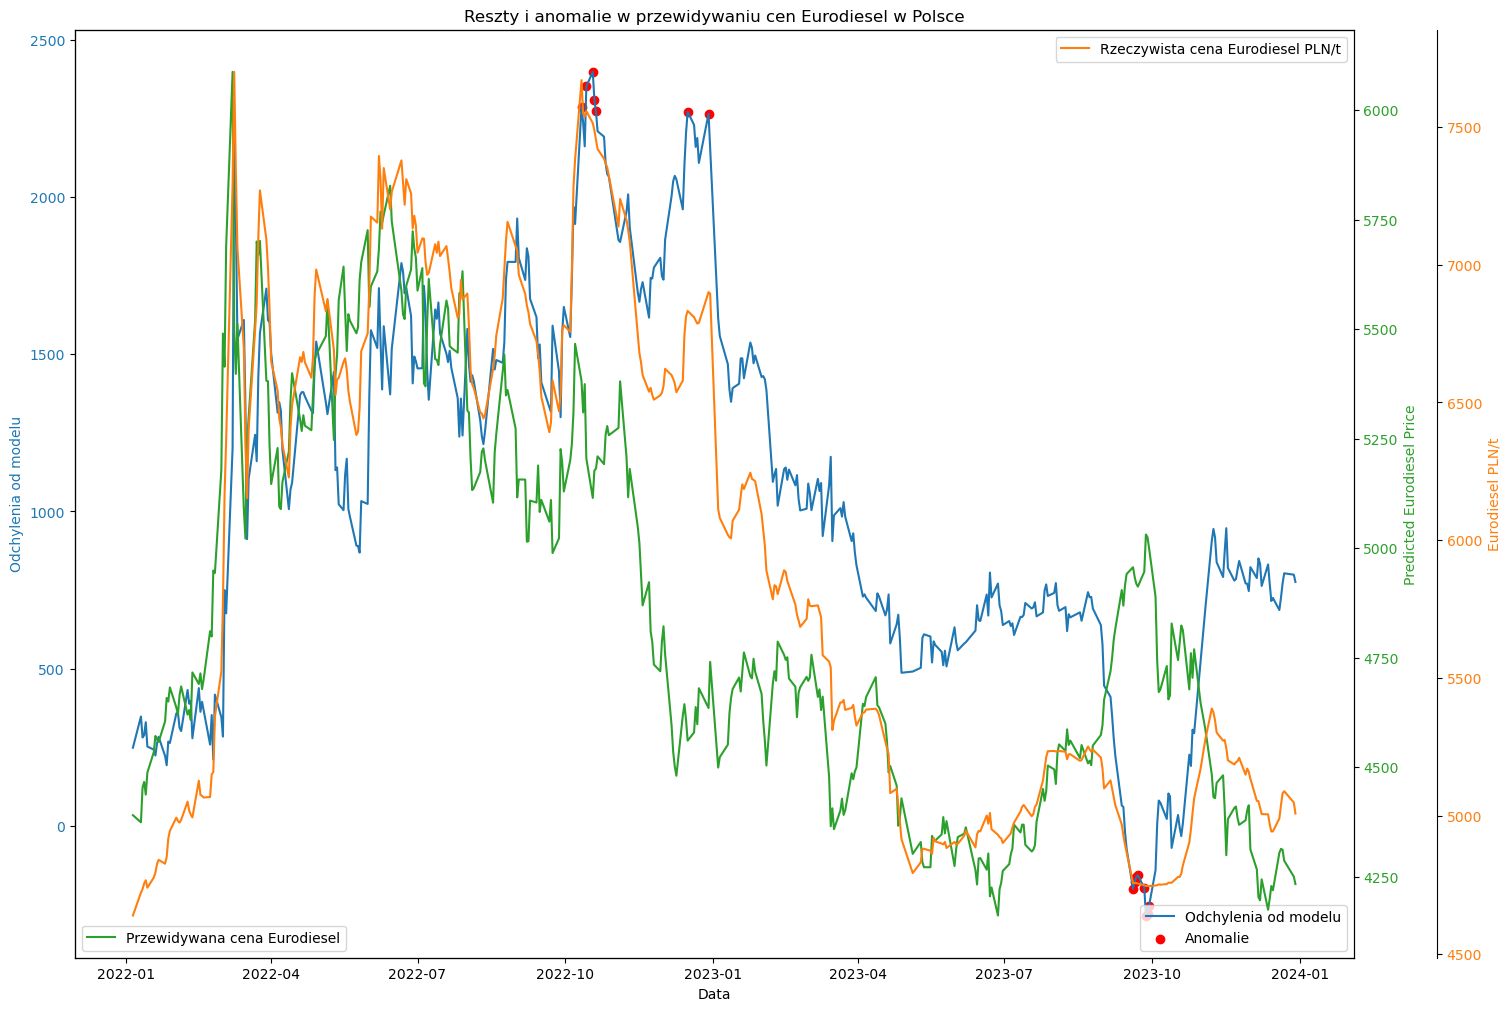

In [103]:
# Visualization of deviations from model, model prices and actual prices of Eurodiesel fuel
import matplotlib.pyplot as plt

anomalies = brent_PLN_2022[brent_PLN_2022['Anomaly'] == 'Anomaly']
fig, ax1 = plt.subplots(figsize=(15, 10), constrained_layout=True)

color = 'tab:blue'
ax1.set_xlabel('Data')
ax1.set_ylabel('Odchylenia od modelu', color=color)
ax1.plot(brent_PLN_2022.index, brent_PLN_2022['Residuals'], color=color, label = 'Odchylenia od modelu')
ax1.tick_params(axis='y', labelcolor=color)

# Addition of scatter plot for anomalies
ax1.scatter(anomalies.index, anomalies['Residuals'], color='red', label='Anomalie')

ax2 = ax1.twinx()
color = 'tab:green'
ax2.set_ylabel('Predicted Eurodiesel Price', color=color)
ax2.plot(brent_PLN_2022.index, brent_PLN_2022['Predicted Eurodiesel Price'], color=color, label = 'Przewidywana cena Eurodiesel')
ax2.tick_params(axis='y', labelcolor=color)

ax3 = ax1.twinx()
color = 'tab:orange'
ax3.spines['right'].set_position(('outward', 60))      
ax3.set_ylabel('Eurodiesel PLN/t', color=color)
ax3.plot(brent_PLN_2022.index, brent_PLN_2022['Eurodiesel'], color=color, label = 'Rzeczywista cena Eurodiesel PLN/t')
ax3.tick_params(axis='y', labelcolor=color)

plt.title('Reszty i anomalie w przewidywaniu cen Eurodiesel w Polsce')
 

ax1.legend(loc='lower right')  
ax2.legend(loc='lower left')  
ax3.legend(loc='upper left', bbox_to_anchor=(1.15, 1))

plt.legend()
plt.show()

### 4.3 Polynomial modeling
To verify the results based on the linear model, an analysis using a polynomial model will be carried out. However, in order to optimally tune the amount of data to be learned and the complexity of the model, a learning curve and a model validation curve will first be defined.

#### 4.3.1 Development of a learning curve

In [104]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import learning_curve, validation_curve
from sklearn.pipeline import Pipeline

In [105]:
# Preparation of polynomial data for the entire dataset
poly = PolynomialFeatures(degree=3)
X_poly = poly.fit_transform(X)

In [106]:
# Generation of learning curves
train_sizes, train_scores, validation_scores = learning_curve(
    estimator=LinearRegression(), X=X_poly, y=y, train_sizes=np.linspace(0.1, 1.0, 10), cv=5, scoring='neg_mean_squared_error')

In [107]:
# Calculation of mean and standard deviation for training and validation results
train_scores_mean = -train_scores.mean(axis=1)
validation_scores_mean = -validation_scores.mean(axis=1)
train_scores_std = train_scores.std(axis=1)
validation_scores_std = validation_scores.std(axis=1)

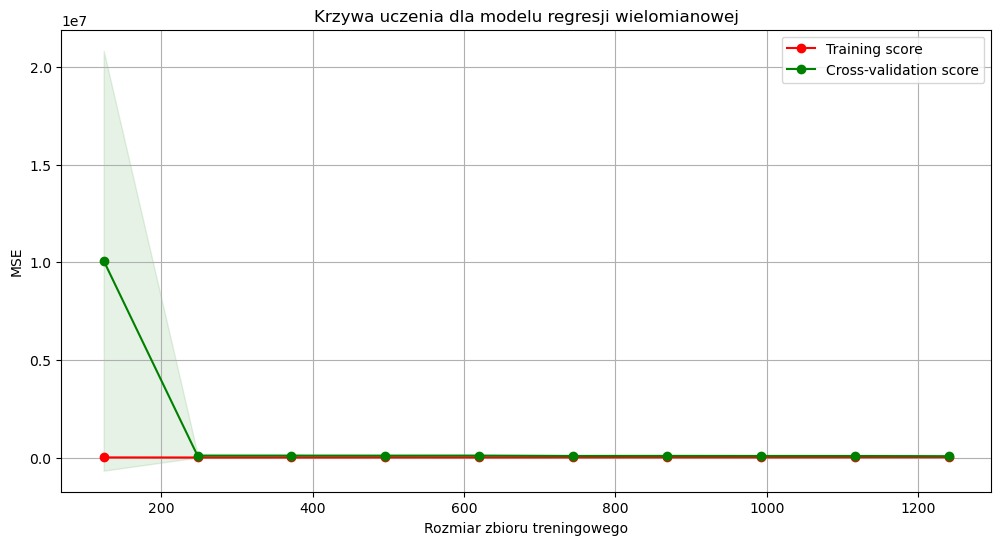

In [108]:
# Drawing learning curves
plt.figure(figsize=(12, 6))
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, validation_scores_mean, 'o-', color="g", label="Cross-validation score")

plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, validation_scores_mean - validation_scores_std,
                 validation_scores_mean + validation_scores_std, alpha=0.1, color="g")

plt.title("Krzywa uczenia dla modelu regresji wielomianowej")
plt.xlabel("Rozmiar zbioru treningowego")
plt.ylabel("MSE")
plt.legend(loc="best")
plt.grid()
plt.show()

#### 4.3.2 Development of a validation curve

In [109]:
# Wybieramy stopień wielomianu jako parametr do badania
param_range = np.arange(1, 10)  # Przykładowy zakres dla stopnia wielomianu od 1 do 9

# Generowanie krzywej walidacji
train_scores, test_scores = validation_curve(
    estimator=Pipeline([("poly", PolynomialFeatures()), ("linear", LinearRegression())]),
    X=X, y=y,
    param_name="poly__degree",  # Nazwa parametru do zmiany
    param_range=param_range,    # Zakres wartości parametru
    cv=5,                       # Liczba foldów w walidacji krzyżowej
    scoring="neg_mean_squared_error",  # Metryka oceny
    n_jobs=-1                   # Użycie wszystkich dostępnych rdzeni CPU
)

In [110]:
# Obliczenie średniej i odchylenia standardowego dla wyników treningowych i testowych
train_scores_mean = -train_scores.mean(axis=1)
validation_scores_mean = -test_scores.mean(axis=1)
train_scores_std = train_scores.std(axis=1)
validation_scores_std = test_scores.std(axis=1)

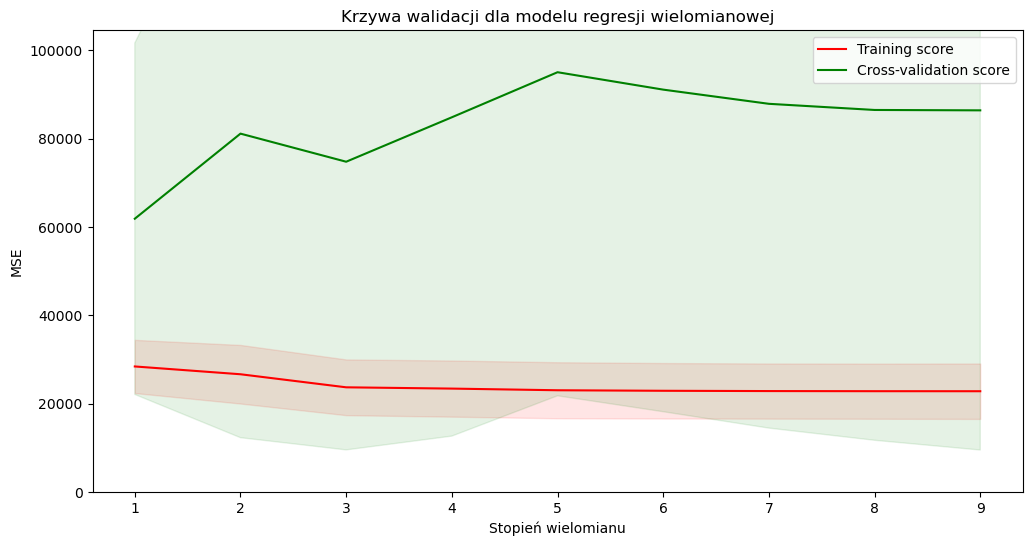

In [111]:
# Rysowanie krzywej walidacji
plt.figure(figsize=(12, 6))
plt.title("Krzywa walidacji dla modelu regresji wielomianowej")
plt.xlabel("Stopień wielomianu")
plt.ylabel("MSE")
plt.ylim(0, max(train_scores_mean.max(), validation_scores_mean.max()) * 1.1)  # Dostosuj górny limit osi y
plt.xticks(param_range)
plt.plot(param_range, train_scores_mean, label="Training score", color="red")
plt.plot(param_range, validation_scores_mean, label="Cross-validation score", color="green")

plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(param_range, validation_scores_mean - validation_scores_std,
                 validation_scores_mean + validation_scores_std, alpha=0.1, color="g")

plt.legend(loc="best")
plt.show()

On the basis of the analyses carried out on the complexity of the model and its predictive ability, it was decided to opt for a 3rd degree polynomial model.

#### 4.3.3 Performing polynomial modelling

In [112]:
# Model preparation
X_poly_train = poly.fit_transform(X_train)
X_poly_test = poly.transform(X_test)

In [113]:
# Training the model
model = LinearRegression()
model.fit(X_poly_train, y_train)

LinearRegression()

In [114]:
# Predicting on a test set
y_poly_pred = model.predict(X_poly_test)

In [115]:
# Model evaluation
poly_mse = mean_squared_error(y_test, y_poly_pred)
poly_r2 = r2_score(y_test, y_poly_pred)

print(f"MSE: {poly_mse}")
print(f"R^2: {poly_r2}")

MSE: 26141.40589934001
R^2: 0.8541607100883658


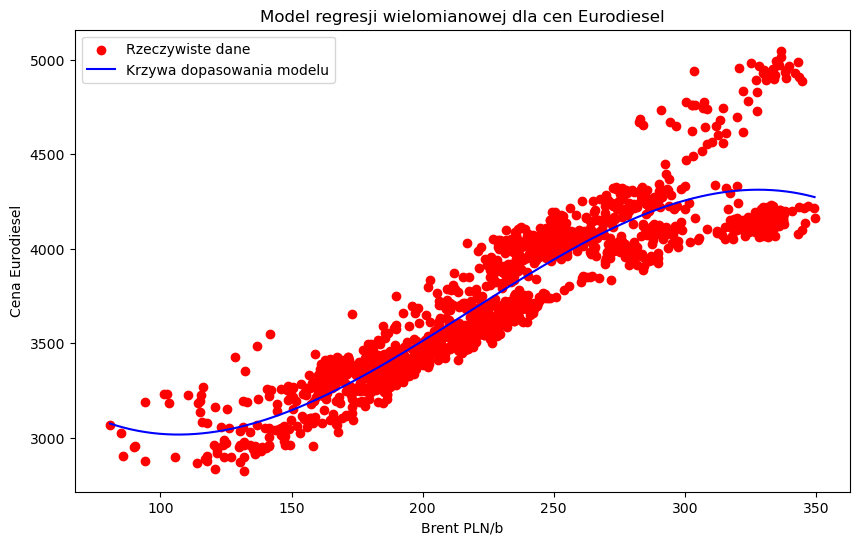

In [116]:
# Generowanie równomiernie rozłożonych wartości w zakresie X
X_fit = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)
X_fit_df = pd.DataFrame(X_fit, columns=['Brent PLN/b'])
X_fit_transformed = poly.transform(X_fit_df)
y_fit = model.predict(X_fit_transformed)

plt.figure(figsize=(10, 6))
plt.scatter(X, y, color='red', label='Rzeczywiste dane') 
plt.plot(X_fit, y_fit, color='blue', label='Krzywa dopasowania modelu')
plt.title('Model regresji wielomianowej dla cen Eurodiesel')
plt.xlabel('Brent PLN/b')
plt.ylabel('Cena Eurodiesel')
plt.legend()
plt.show()